# Analysis of Policy and Value Heads

In [1]:
import os
os.chdir('../src')
import numpy as np
import matplotlib.pyplot as plt
import torch
from engine import BigBoard
from dataset import board_to_planes
from network import UTTTNet
from tree import Root
from net_player import NetTree

In [2]:
def load_model(name):
    m = UTTTNet()
    m.load_state_dict(torch.load(f'../models/{name}.pt', map_location='cpu'))
    return m.eval()

def policy_head(m, board):
    with torch.no_grad():
        p, v = m(board_to_planes(board))
        print(f'Value: {v.item()}')
    return p[0].exp().numpy()

def value_head(m, board):
    v = np.full((9,9), np.nan)
    for i,j in np.ndindex(9,9):
        if not board.legal_moves[i][j]:
            continue
        b = board.copy()
        b.move(i, j)
        with torch.no_grad():
            _, value = m(board_to_planes(b))
        v[i, j] = value
    v = torch.tensor(v).view(3, 3, 3, 3)
    v = torch.cat(v.chunk(3, dim=0), dim=2)
    v = torch.cat(v.chunk(3, dim=1), dim=3)
    return v.squeeze().numpy()


cm = plt.cm.RdBu
cm.set_bad('gray')    
def plot_heads(p, v):
    plt.figure(figsize=(11, 4))
    plt.subplot(121)
    plt.imshow(100*p, vmin=0)
    plt.colorbar()
    plt.title('Policy Head (%)')
    
    plt.subplot(122)
    vmax = 100*np.nanmax(np.abs(v))
    plt.imshow(100*v, vmin=-vmax, vmax=vmax, cmap=cm)
    plt.colorbar()
    plt.title('Value Head (centi)')
    
    plt.show()

In [3]:
b = BigBoard(boards=[
    (1,0,0,0,0,0,0,2,2),
    (0,2,2,0,0,1,1,0,0),
    (0,0,2,1,0,1,1,0,0),
    (0,0,0,2,0,0,1,1,1),
    (0,0,2,0,2,0,2,0,1),
    (0,2,0,2,1,0,0,2,0),
    (0,0,1,0,0,1,2,2,2),
    (0,1,0,2,1,0,0,1,0),
    (1,1,1,0,0,2,0,0,2)
], mover=1, sectors=(2,))
b.draw()

c = b.copy()
c.move(2,4)

game1 = [(4, 4), (4, 0), (0, 5), (5, 5), (5, 7), (7, 7), (7, 5), (5, 8), (8, 3), (3, 3), (3, 7), (7, 8), (8, 0), (0, 0), (0, 8), (8, 6), (6, 5), (5, 2), (2, 3), (3, 6), (6, 8), (8, 8), (8, 1), (1, 1), (1, 3), (3, 0), (0, 2), (2, 2), (2, 6), (6, 2), (2, 0), (4, 6), (6, 1), (1, 8), (8, 2), (4, 3)]
game2 = [(4, 4), (4, 6), (6, 6), (6, 1), (1, 1), (1, 5), (5, 5), (5, 0), (0, 0), (0, 1), (1, 2), (2, 1), (1, 0), (0, 8), (8, 8), (8, 0), (0, 3), (3, 2), (2, 2), (2, 6), (6, 0), (0, 2), (2, 5), (5, 7), (7, 7), (7, 8), (8, 5), (5, 6), (6, 3), (3, 8), (8, 2), (2, 7), (7, 2), (2, 4), (4, 5), (5, 3), (3, 3), (3, 7), (7, 4), (4, 0), (0, 4), (4, 1), (7, 1)]
win1 = BigBoard()
for m in game1[:-1]: win1.move(*m)
win2 = BigBoard()
for m in game2[:-1]: win2.move(*m)

     X │   │   ┃   │ O │ O ┃   │   │ O 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │   ┃   │   │ X ┃ X │   │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │ O │ O ┃ X │   │   ┃ X │   │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │   ┃   │   │ O ┃   │ O │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     O │   │   ┃   │ O │   ┃ O │ X │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     X │ X │ X ┃ O │   │ X ┃   │ O │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │ X ┃   │ X │   ┃ X │ X │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │ X ┃ O │ X │   ┃   │   │ O 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     O │ O │ O ┃   │ X │   ┃   │   │ O         
Mover: O, sector: (2,)
       │   │   
    ───┼───┼───
     X │ O │   
    ───┼───┼───
     O │ X │ X     


* 2,1 is win for O in 2
* 2,0 is win for O in 3
* Other moves, X plays 2,0 to win the sector and guarantee at least a draw

### 1000 games

In [185]:
m = load_model('newplane_from00000_100_1000bs2048lr0.1d0.001e3')

Value: -0.009546143934130669


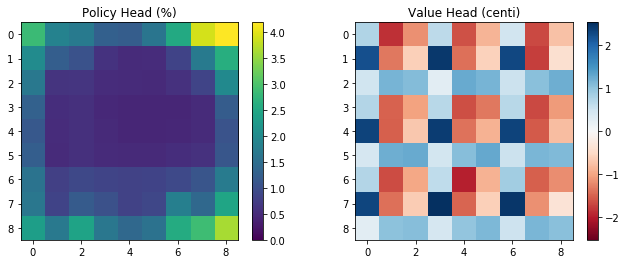

In [186]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.1438795030117035


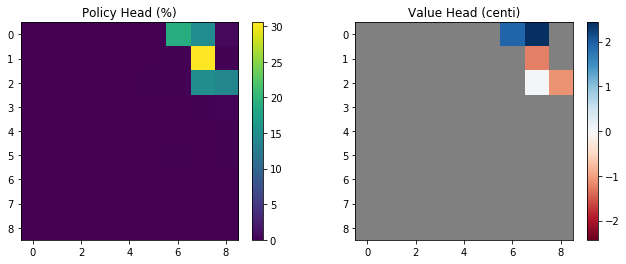

In [187]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

### 1500 games

In [188]:
m = load_model('from00000_150_1500bs2048lr0.1d0.001e3')

Value: 0.0068755438551306725


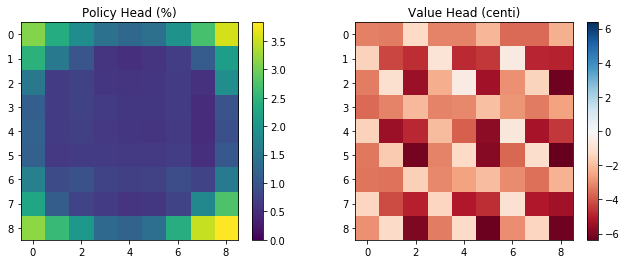

In [189]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: 0.13355468213558197


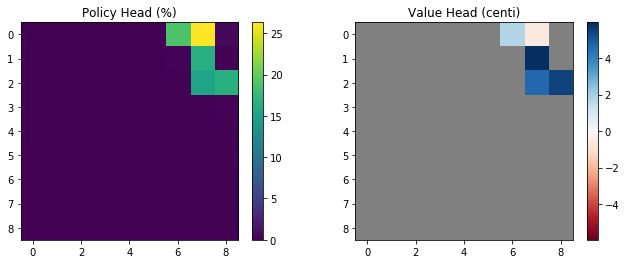

In [190]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

### 2000 games
* Value head strongly prefers center point, enough to dominate puct
* Value head finds the right moves in test position 

In [20]:
m = load_model('scr_dl_200_2000bs2048lr0.1d0.001e3')

Value: 0.09987792372703552


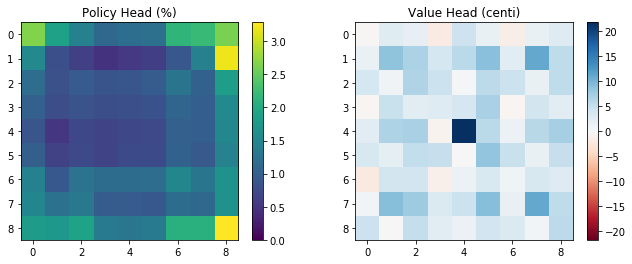

In [36]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.014521576464176178


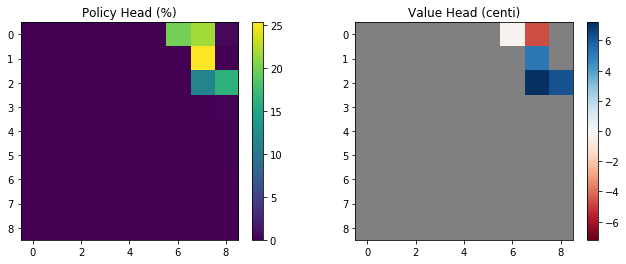

In [70]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

In [41]:
t = NetTree(b, Root(), model=m, noise=False)

In [179]:
for _ in range(490): t.explore()

In [184]:
puct = (t.sign*t.Q + 2.0*t.P*np.sqrt(t.N.sum()))/t.N
print(t.N)
print(t.Q_over_N())
print(puct)
print(t.terminal)
print(t.N.sum())
print(t.v)

[312 121  30  13  19]
[-0.30173505 -1.          0.0171367   0.04579789  0.03273822]
[0.33030287 1.08007939 0.35801147 0.3448362  0.35071704]
[False  True False False False]
495
-1.0


### 2500 games
* Value head continues to prefer center point (see selfplay %X-O)
* Value head more accurately evaluates test position.
* Policy head finds the correct move for test position.

In [7]:
m = load_model('250_2500bs2048lr0.1d0.001e4')

Value: 0.038062579929828644


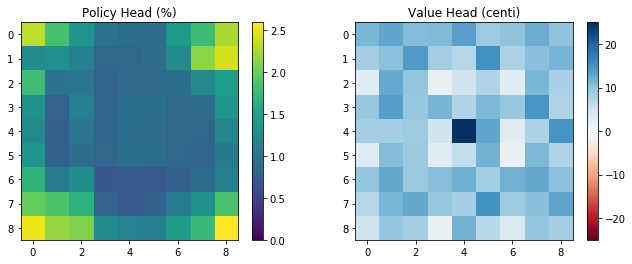

In [8]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.2829713523387909


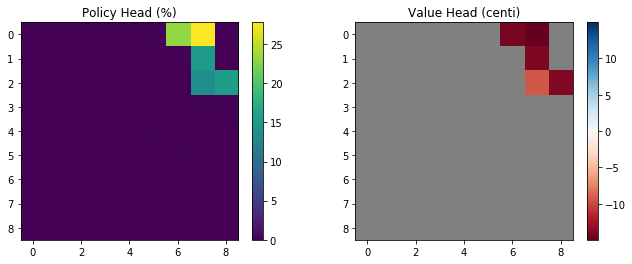

In [9]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

### 3000 games
* Policy starting to put more weight on center sector, but still prefers corner.
* Value head sees X advantage for every first move, so prefers center position less strongly.

In [7]:
m = load_model('300_3000bs2048lr0.1d0.001e4')

Value: 0.06882303953170776


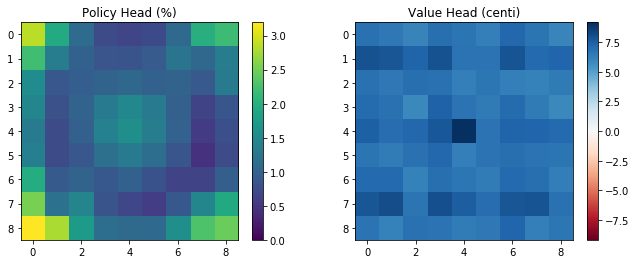

In [8]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.2364179641008377


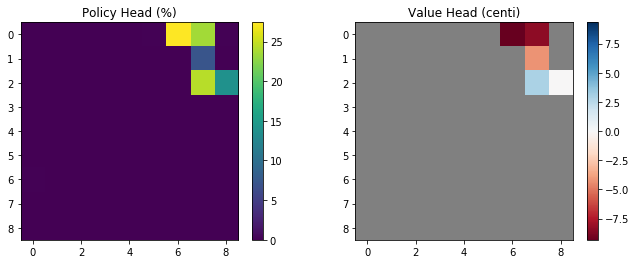

In [9]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

Value: -0.04211409389972687


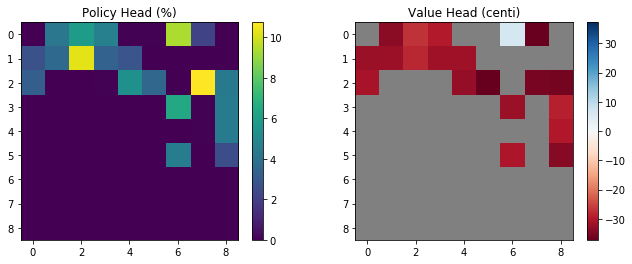

In [8]:
p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value head finds the solution immediately. Policy also helpful.

### 3500 games
* Policy very flat.
* Value lower for starting position. Value head sees O advantage for many moves that don't take the center.

In [7]:
m = load_model('350_3500bs2048lr0.1d0.001e5')

Value: 0.03639873117208481


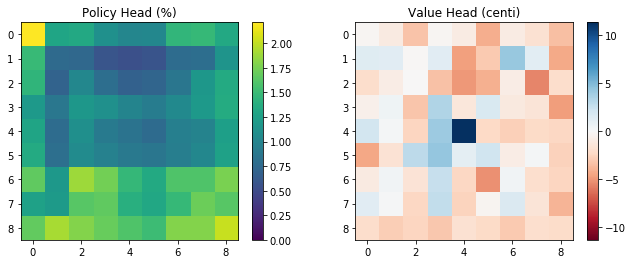

In [8]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.34219375252723694


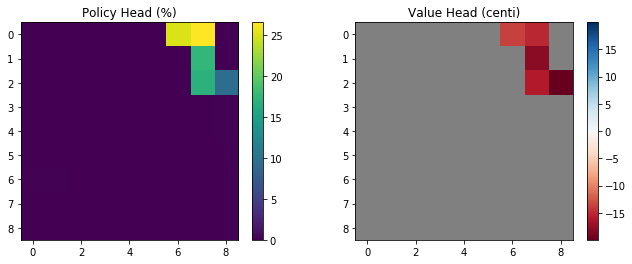

In [9]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

Although value head selects the incorrect move, it quickly finds the right one with a few nodes (~10) of search because the drawing response by X has strong policy and value head.

Value: -0.17929327487945557


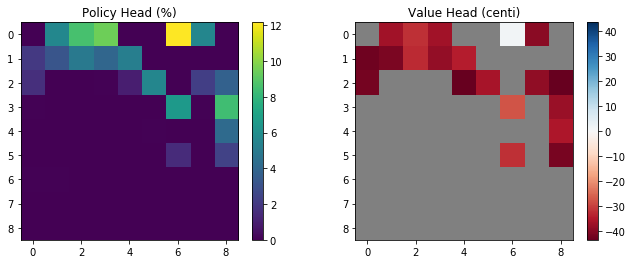

In [17]:
p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

### 4000 games
* Policy very flat. Value head still prefers center but shifting to center coners and some other spots as well.

In [10]:
m = load_model('400_4000bs2048lr0.1d0.001e4')

Value: 0.06669244915246964


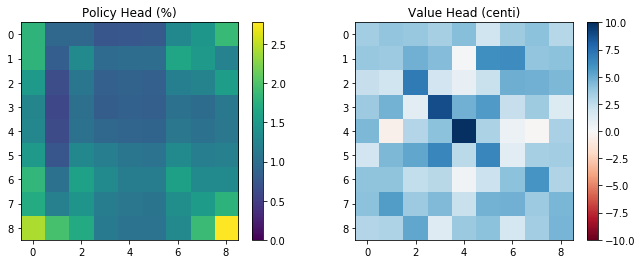

In [13]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.33445626497268677


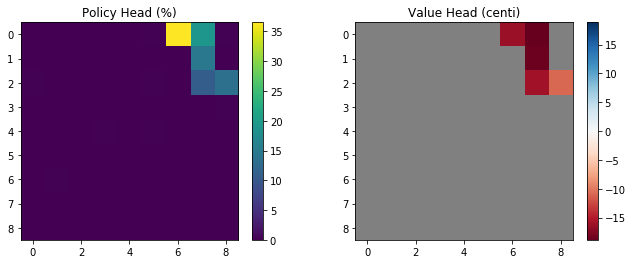

In [14]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

Value: -0.18454132974147797


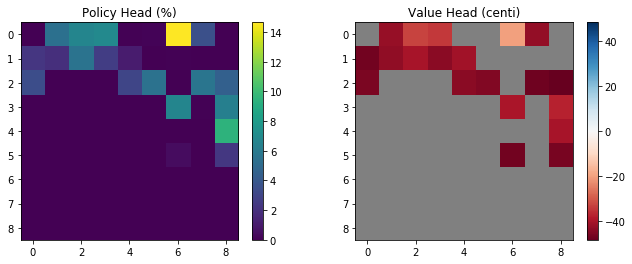

In [15]:
p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.590959370136261


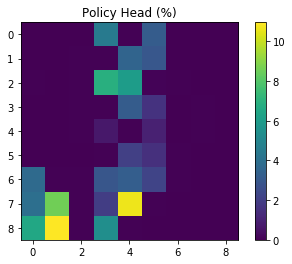

In [192]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Due to low policy and opposite value, search finds another move with better value.
#  It takes 1530 nodes to explore the winning move. In fact, it is the last move to be explored.
#  This may partially explain why V-mode is stronger than N-mode. If a good move is found
#  later in the search, it won't have enough time to accumulate more nodes, but value would show it.
#  Unfortunately, the policy is still trained on visit count.
#  TODO: it may be worth training policy on mcts value, but I don't think I saved that info.

### 4500 games
* Policy still flat. Still prefers corner corners, but starting to get weight in the center as well.
* Value head still prefers center center, but also prefering center corner and centers of other sectors.

In [8]:
m = load_model('450_4500bs2048lr0.1d0.001e4')

Value: 0.04645616188645363


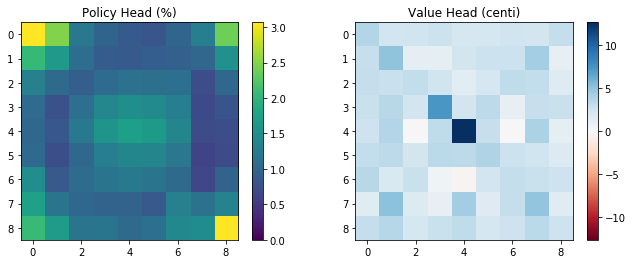

In [9]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.27648696303367615


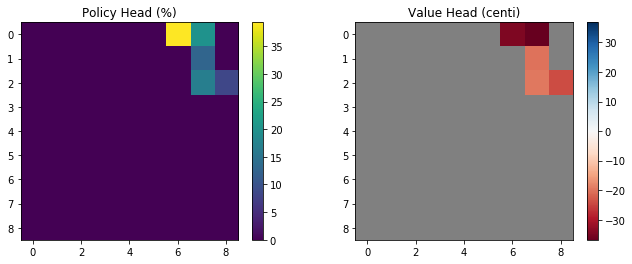

In [10]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

Value: -0.19842693209648132


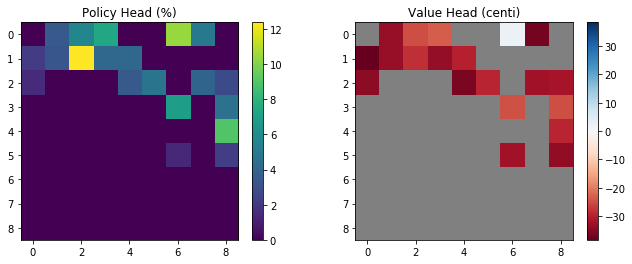

In [11]:
p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.4480418860912323


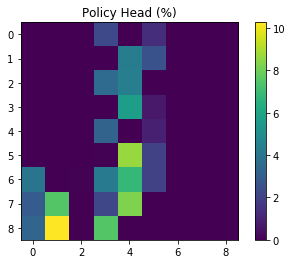

In [12]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# However, there is enough policy that search finds the answer quickly: 30 nodes

### 5000 games
* Policy corner and central area.
* Value is very close to zero for starting position. Prefers center and corner of center and center of corners.

In [8]:
m = load_model('500_5000bs2048lr0.1d0.001e4')

Value: -0.006918830331414938


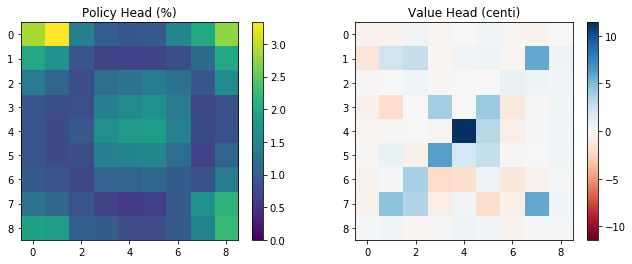

In [9]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.4092821180820465


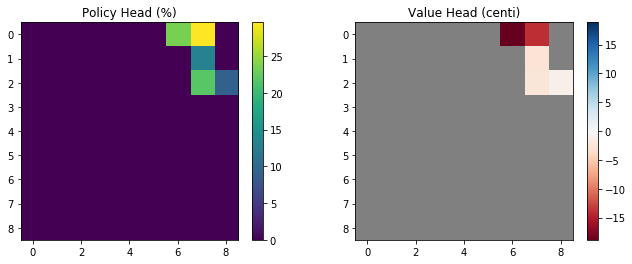

In [10]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

Value: -0.0258361604064703


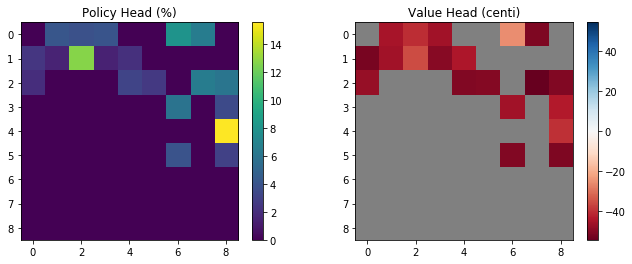

In [11]:
p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.29342737793922424


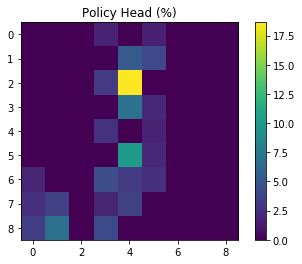

In [41]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# However, there is enough policy that search finds the answer quickly: 30 nodes

### 6000 games
* Policy corner and central area.
* Value is very close to zero for starting position. Prefers center and corner of center and center of corners.
* For deeper positions, this network is very biased towards X. However, policy and value can still find the right moves.

In [8]:
m = load_model('600_6000bs2048lr0.1d0.001e4')

Value: 0.02239932306110859


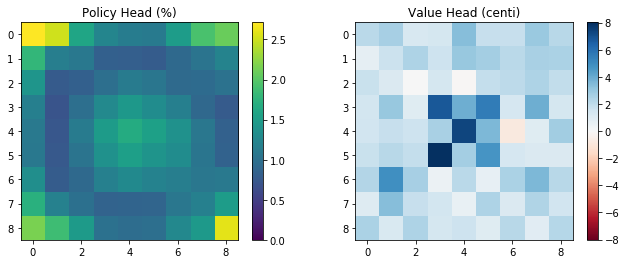

In [9]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: 0.263062983751297


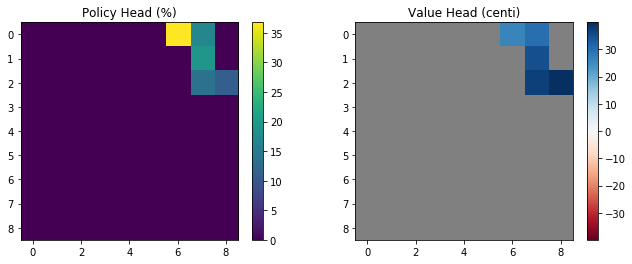

In [10]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

Value: 0.3503175973892212


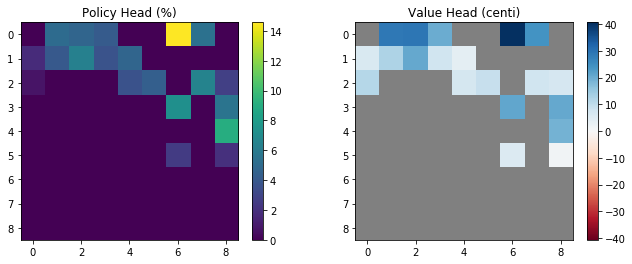

In [11]:
p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.4387238025665283


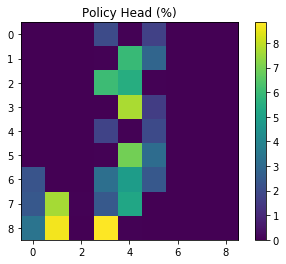

In [12]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 40 nodes

### 7000 games
* Policy corner and central area.
* Value is very close to zero for starting position. Prefers corner of center and center center.
* For deeper positions, this network is very biased towards X. However, policy and value can still find the right moves.
* Both net6k and net7k values are biased toward X, but given last 6-7k selfplay results (record % X wins), it is a justifiable bias.

In [8]:
m = load_model('700_7000bs2048lr0.1d0.001e4')

Value: 0.06519000977277756


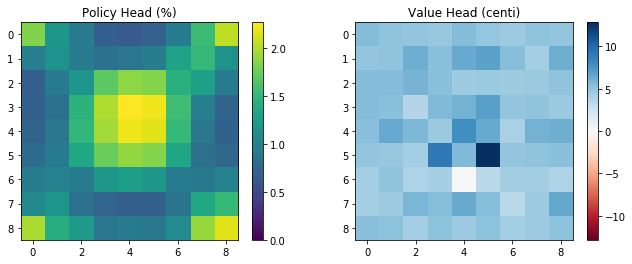

In [9]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: 0.24319173395633698


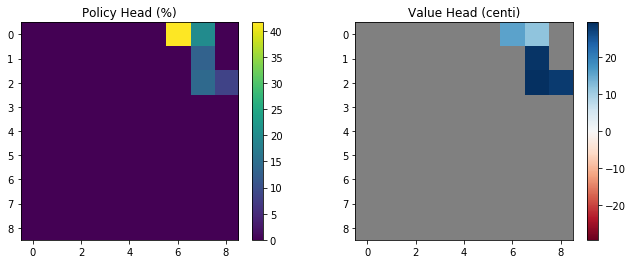

In [10]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

Value: 0.28801584243774414


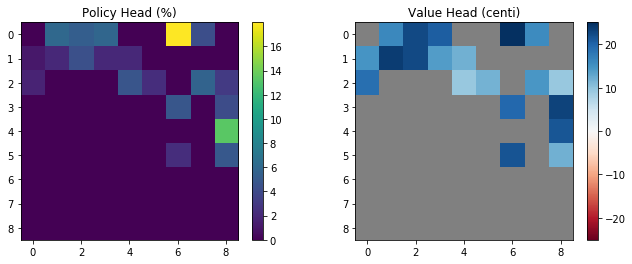

In [11]:
p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.32963669300079346


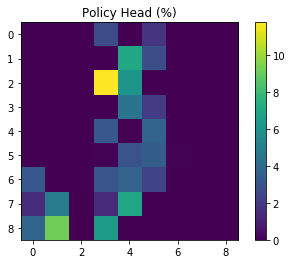

In [12]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 20 nodes though

### 8000 games
* Policy corner and central area (honestly not sure why policy so strong in the corner given value head and selfplay).
* Value is very close to zero for starting position. Prefers corner of center and center center.
* For deeper positions, value is now correctly for O. Both value and policy heads find the correct move.
* Not sure why networks still cannot find the winning move for `win1`.

In [8]:
m = load_model('800_8000bs2048lr0.1d0.001e4')

Value: 0.06687787175178528


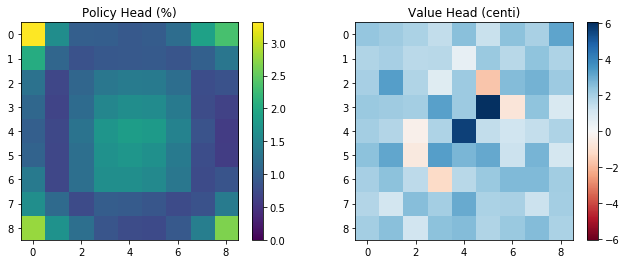

In [9]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.3181537687778473


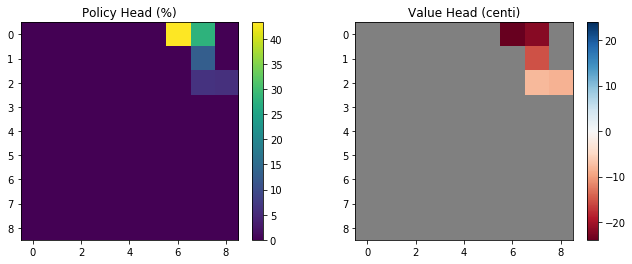

In [10]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

Value: -0.15113548934459686


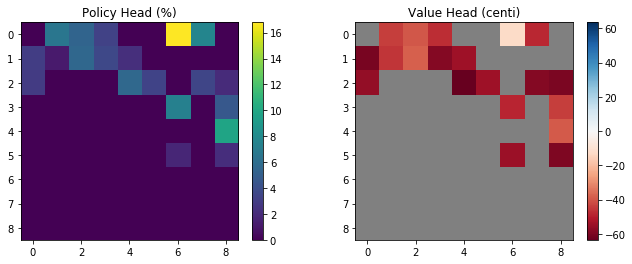

In [11]:
p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.04896783456206322


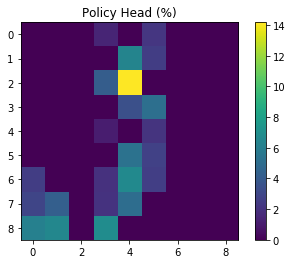

In [12]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 40 nodes

### 9000 games
* Policy corner and central area (honestly not sure why policy so strong in the corner given value head and selfplay).
* Value head very good.
* Not sure why networks still cannot find the winning move for `win1`.

Value: -0.02900850400328636


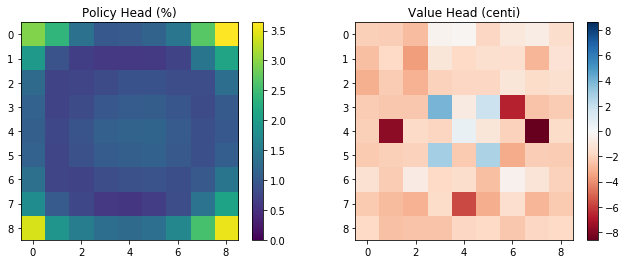

In [8]:
m = load_model('900_9000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.6454023122787476


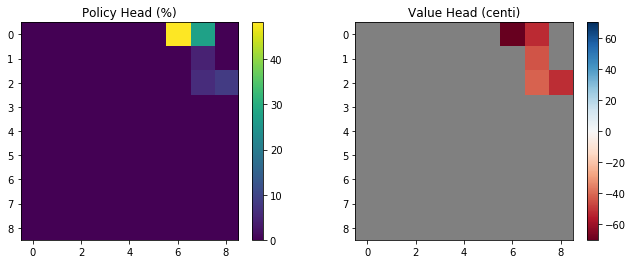

Value: -0.4415072500705719


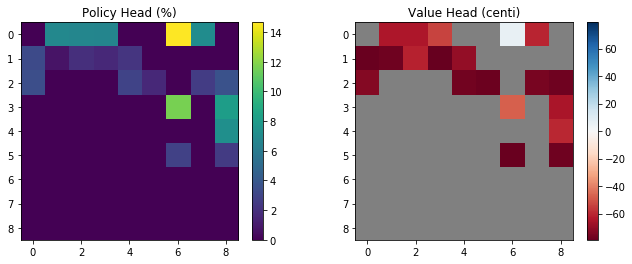

In [9]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.707610011100769


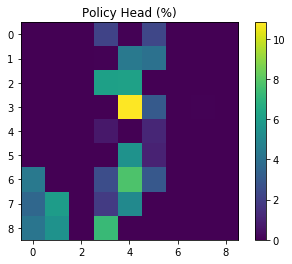

In [10]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 40 nodes

### 10000 games
* Policy corner and central area (honestly not sure why policy so strong in the corner given value head and selfplay).
* Value head very good.
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.03890041261911392


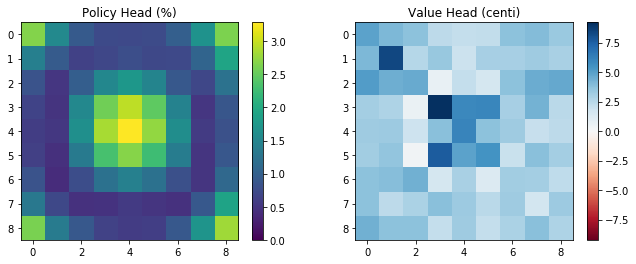

In [8]:
m = load_model('1000_10000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.5274510979652405


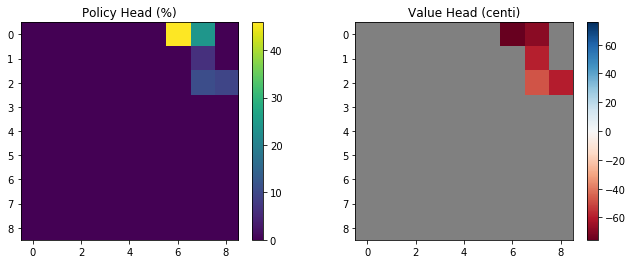

Value: -0.588805615901947


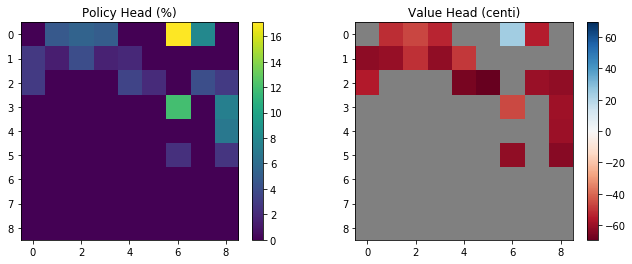

In [9]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.08707991242408752


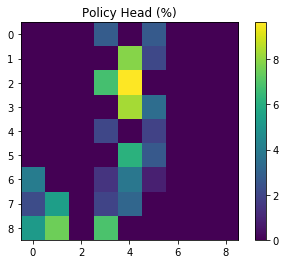

In [10]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 30 nodes

### 11000 games
* Policy corner and central area.
* Value head very good.
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.010308001190423965


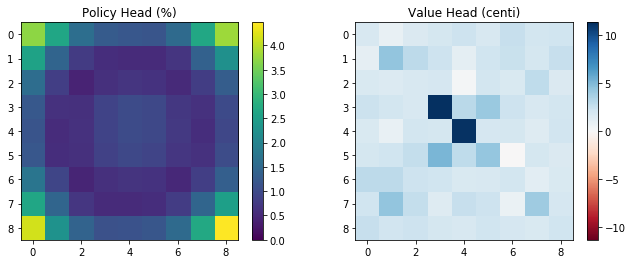

In [8]:
m = load_model('1100_11000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.42450833320617676


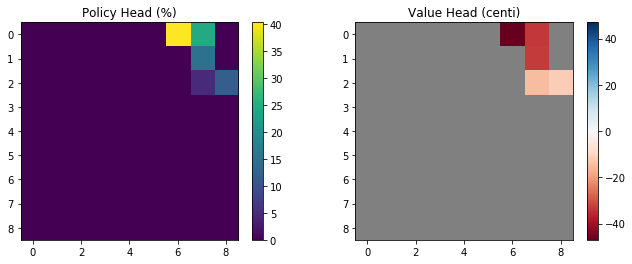

Value: -0.3299461603164673


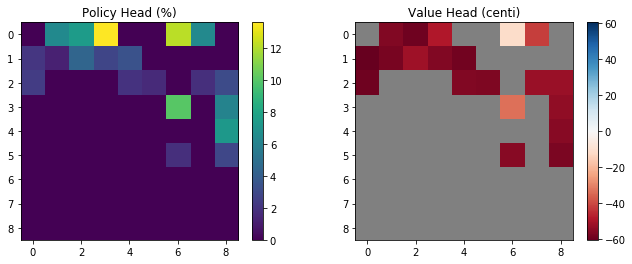

In [9]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.06283791363239288


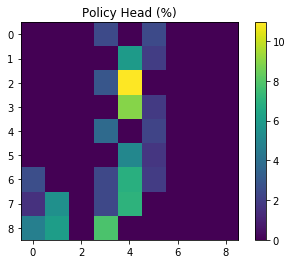

In [10]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 20 nodes

### 12000 games
* Policy corner and central area
* Value head very good.
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.047244008630514145


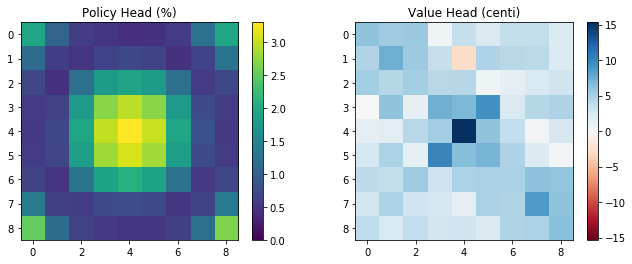

In [8]:
m = load_model('1200_12000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.41280117630958557


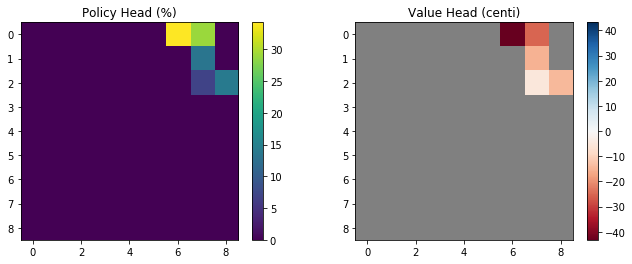

Value: -0.15047729015350342


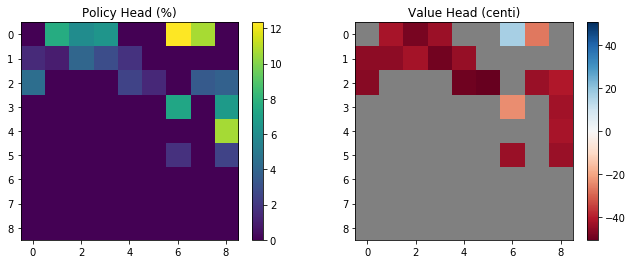

In [9]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.15930283069610596


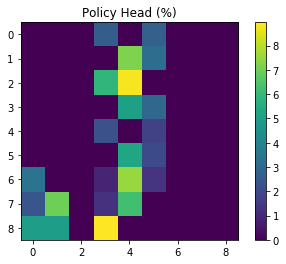

In [10]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 30 nodes

### 13000 games
* Policy corner, value center corners and center
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.002613713499158621


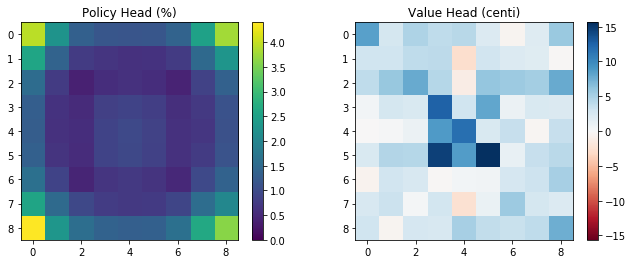

In [5]:
m = load_model('1300_13000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: 0.020373422652482986


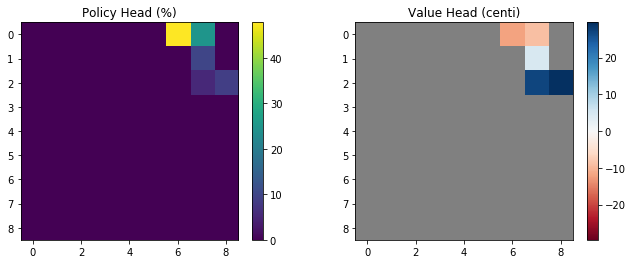

Value: 0.04655172675848007


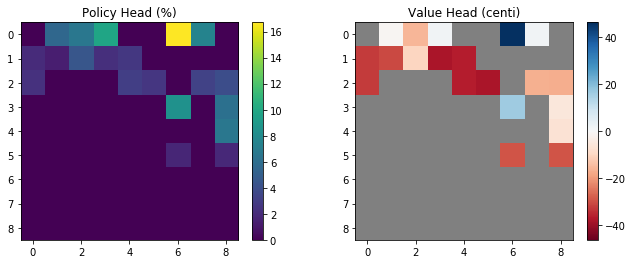

In [6]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.3659643828868866


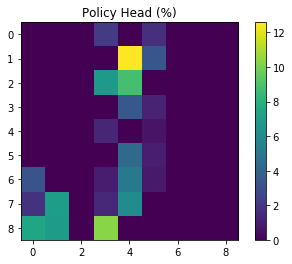

In [7]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 70 nodes

### 14000 games
* Policy: corner. Value: center corners and center
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.02210839092731476


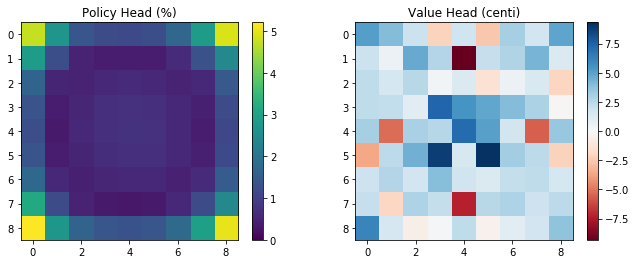

In [4]:
m = load_model('1400_14000bs2048lr0.1d0.001e6')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: 0.16084270179271698


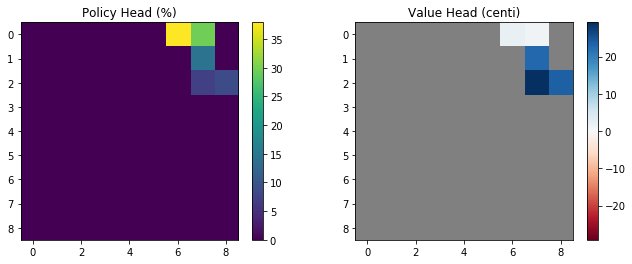

Value: 0.22939100861549377


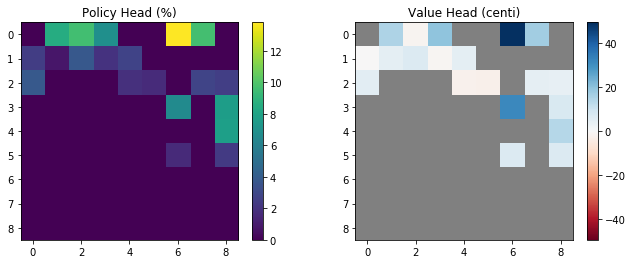

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.19632038474082947


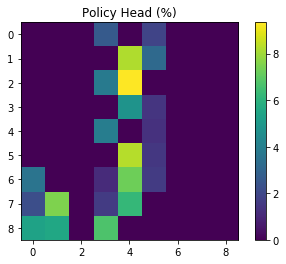

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 20 nodes

### 15000 games
* Policy: corner. Value: center corners and center
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.05622832477092743


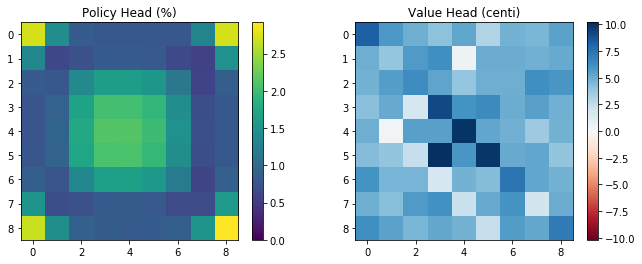

In [5]:
m = load_model('1500_15000bs2048lr0.1d0.001e7')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.2316083312034607


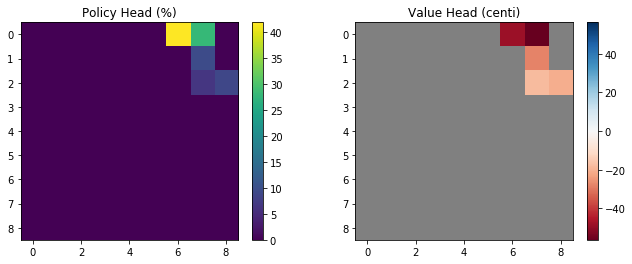

Value: -0.2779676914215088


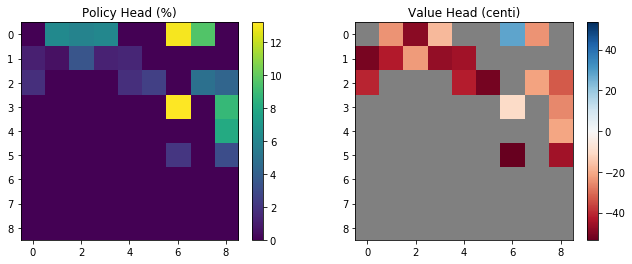

In [6]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.38875144720077515


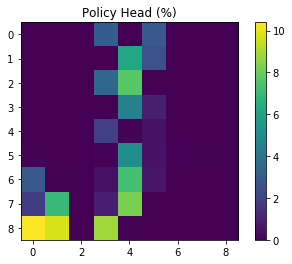

In [7]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 30 nodes

### 16000 games
* Policy: corner and center. 
* Value: center corners and center center, but also now outside corners and corner center.
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.04691801592707634


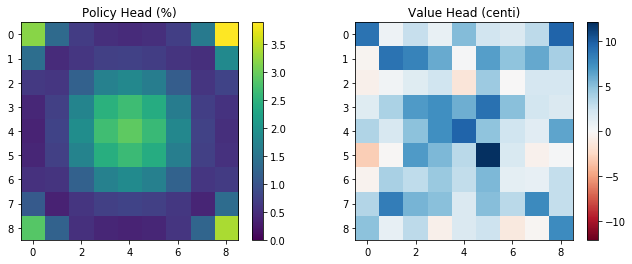

In [4]:
m = load_model('1600_16000bs2048lr0.1d0.001e6')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.05708440765738487


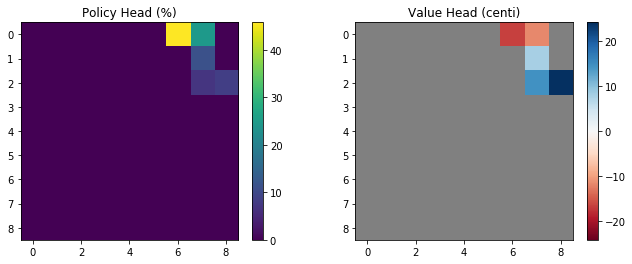

Value: 0.08047226071357727


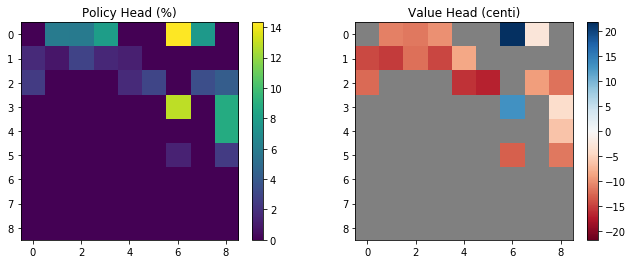

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.04876751825213432


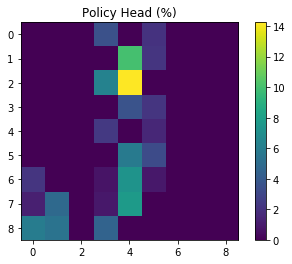

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 30 nodes

### 17000 games
* Policy: corner and center. 
* Value: center corners, but also now outside corners.
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.065383180975914


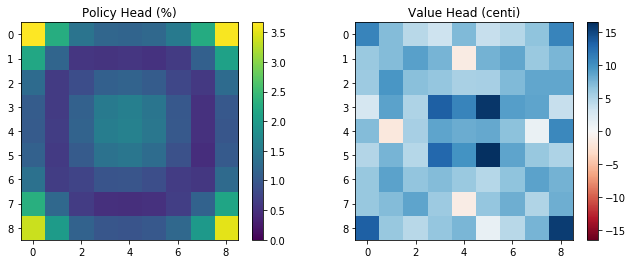

In [4]:
m = load_model('1700_17000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.2586701214313507


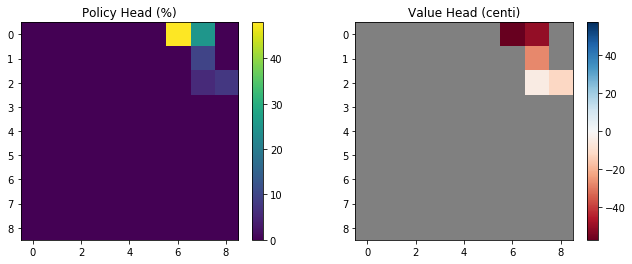

Value: -0.2748638987541199


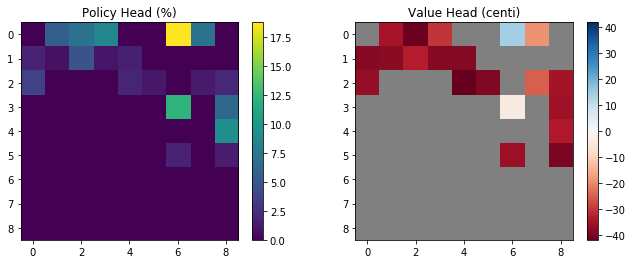

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.5806642770767212


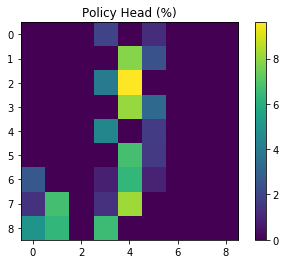

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()
# Wrong value: O wins in 1
# Wrong policy: winning move is center:west
# Finds win in 20 nodes

### 18000 games
* Policy: corner and center. 
* Value: Interesting pattern.
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.06276696920394897


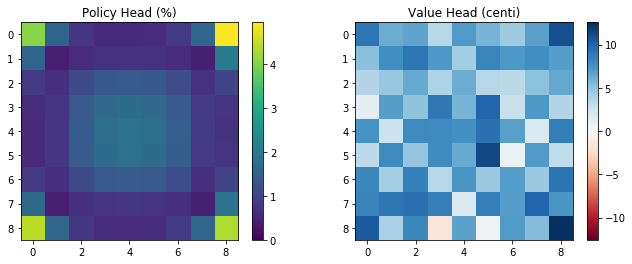

In [4]:
m = load_model('1800_18000bs2048lr0.1d0.001e8')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.34199362993240356


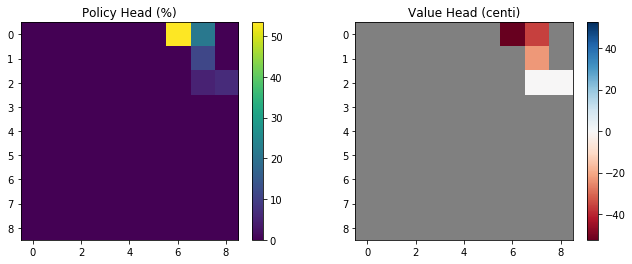

Value: -0.22749954462051392


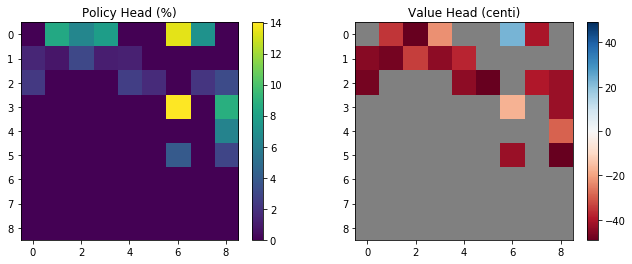

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.34301483631134033


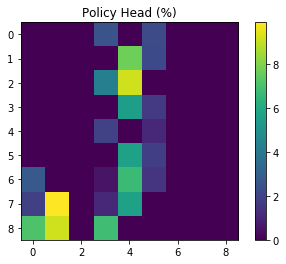

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()

### 19000 games
* Policy: corners, then center next
* Value: center center and corners
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.05380823835730553


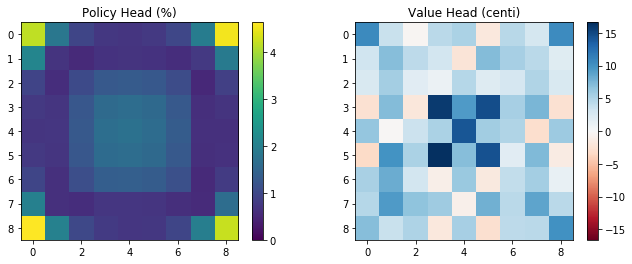

In [7]:
m = load_model('1900_19000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.03290338069200516


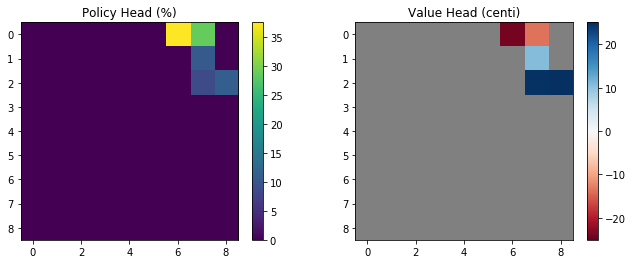

Value: 0.10760603100061417


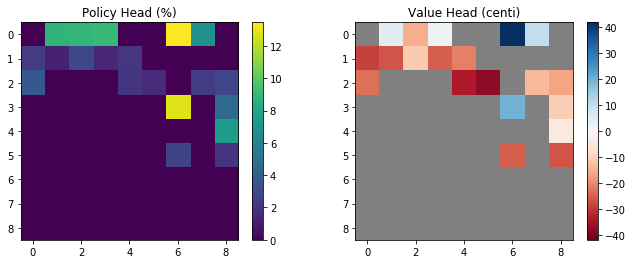

In [8]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.5027135610580444


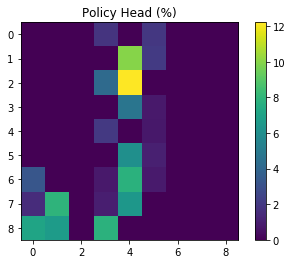

In [9]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()

### 20000 games
* Policy: corners
* Value: Interesting pattern of negative value for centers and corners of edge sectors
* Not sure why networks still cannot find the winning move for `win1`.

Value: 0.029340598732233047


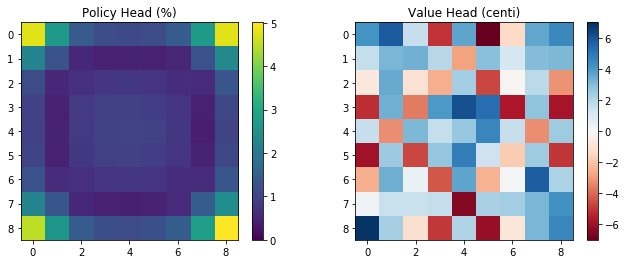

In [33]:
m = load_model('2000_20000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.28600308299064636


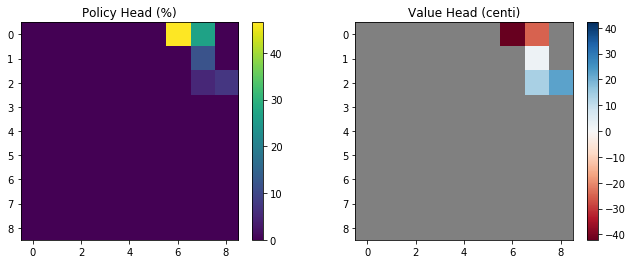

Value: 0.022831542417407036


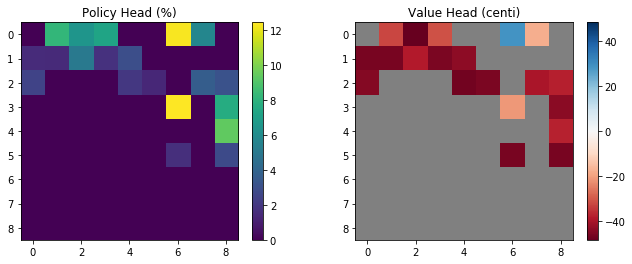

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.5351147651672363


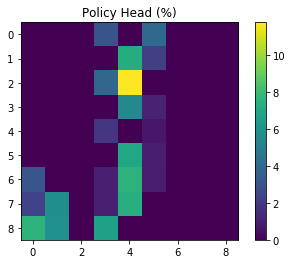

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()

### 22000 games
* Policy: corners
* Value: Corners and center
* Networks probably cannot find winning move because winning moves are <1/100 of all moves

Value: 0.08533789217472076


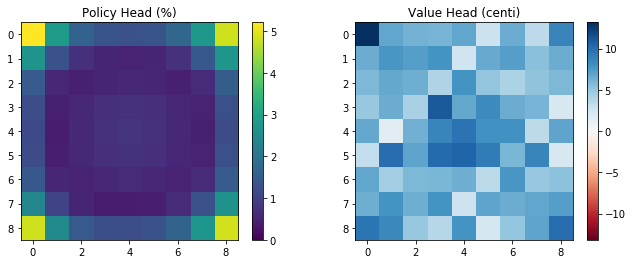

In [4]:
m = load_model('2200_22000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.1358082890510559


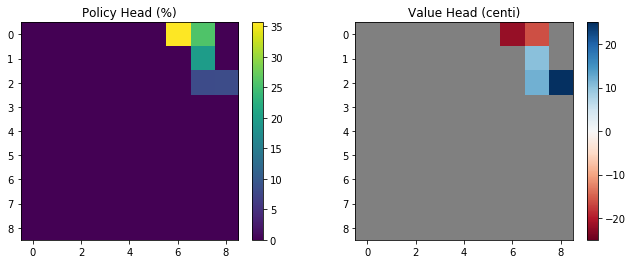

Value: 0.10542438924312592


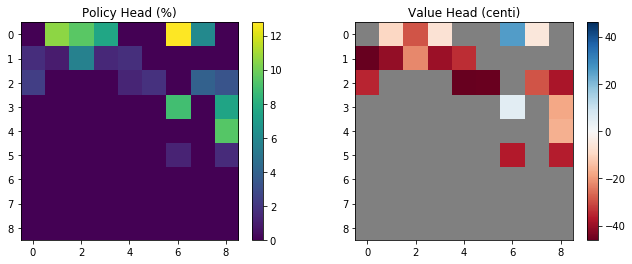

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.5670273900032043


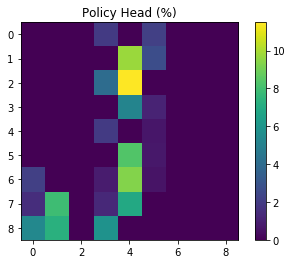

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()

### 24000 games
* Policy: corners, then center
* Value: Corners and center corners
* Networks probably cannot find winning move because winning moves are <1/100 of all moves

Value: 0.06867993623018265


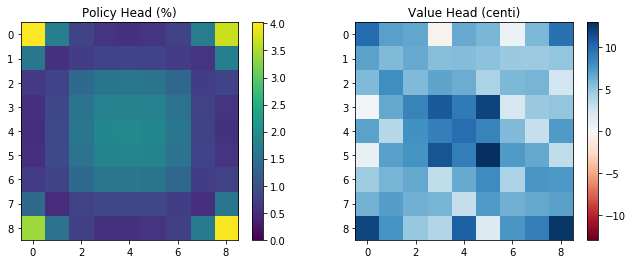

In [4]:
m = load_model('2400_24000bs2048lr0.1d0.001e6')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.04824528843164444


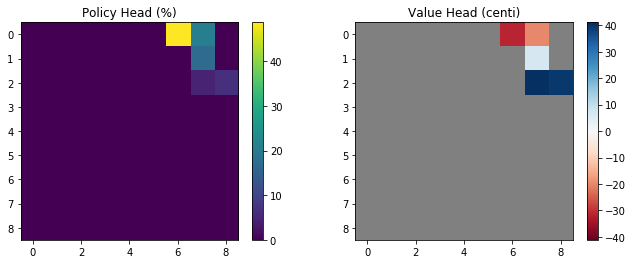

Value: 0.07059557735919952


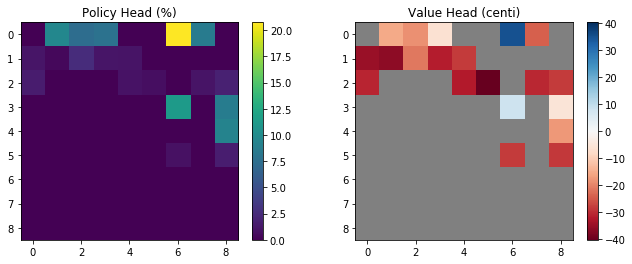

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: 0.15405797958374023


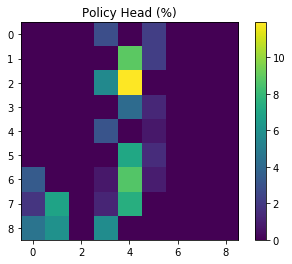

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()

### 26000 games
* Policy: corner
* Value: corners

Value: 0.07180922478437424


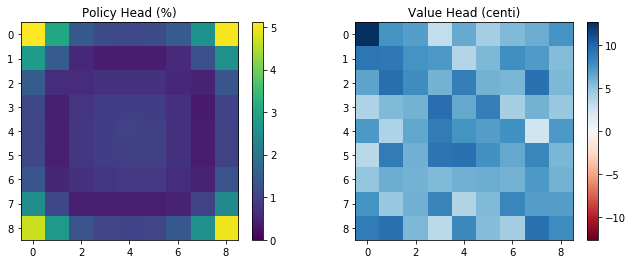

In [4]:
m = load_model('2600_26000bs2048lr0.1d0.001e8')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.196946382522583


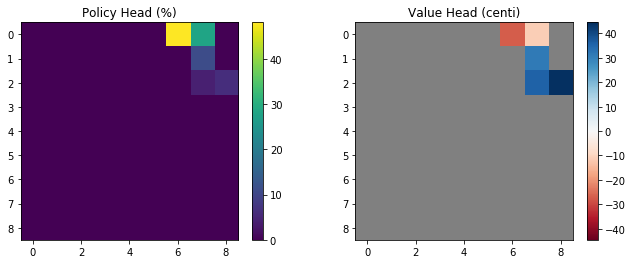

Value: 0.3159674108028412


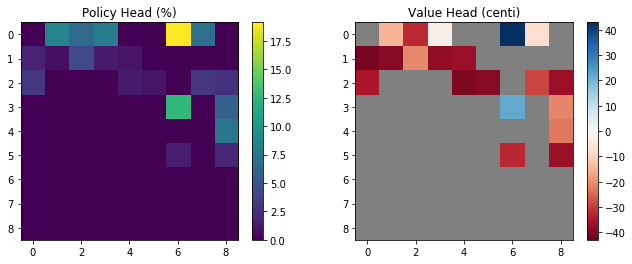

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.4362095296382904


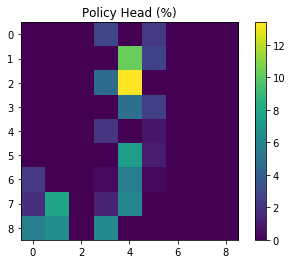

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()

### 28000 games
* Policy: corner
* Value: center center, center corners, corners

Value: 0.04780931770801544


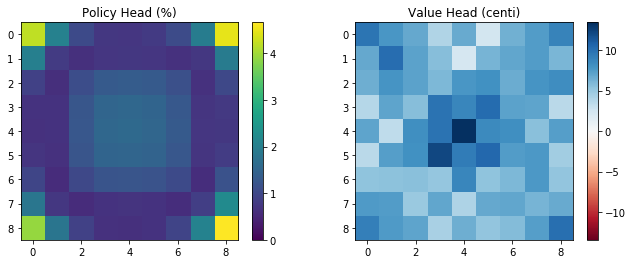

In [4]:
m = load_model('2800_28000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.26915886998176575


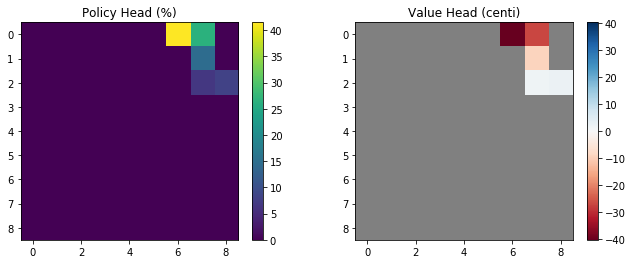

Value: -0.08975628763437271


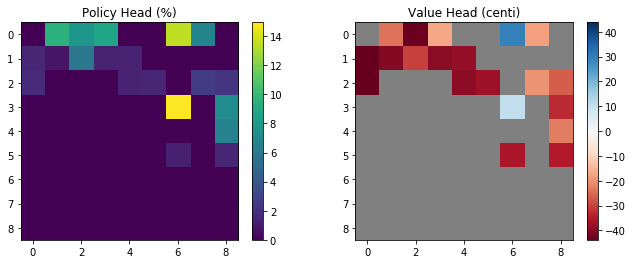

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.4551894962787628


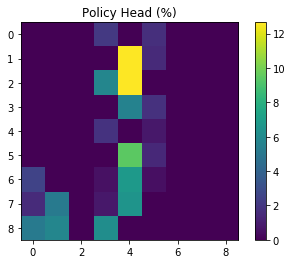

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()

### 30000 games
* Policy: outer corners
* Value: center corners

Value: 0.08274131268262863


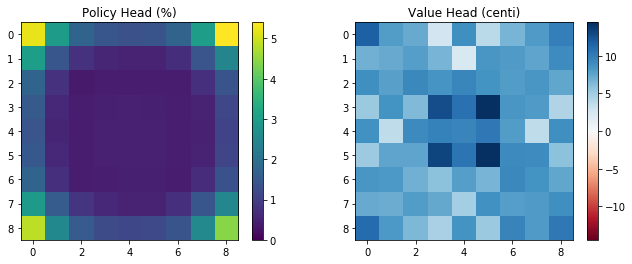

In [4]:
m = load_model('3000_30000bs2048lr0.1d0.001e5')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.2614937722682953


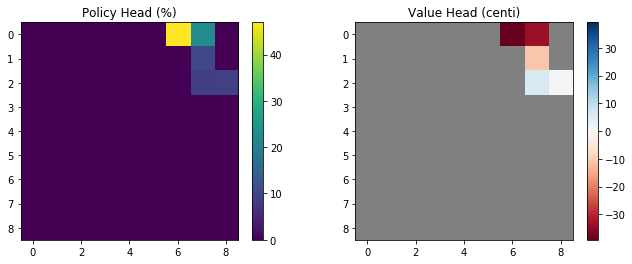

Value: -0.10856001079082489


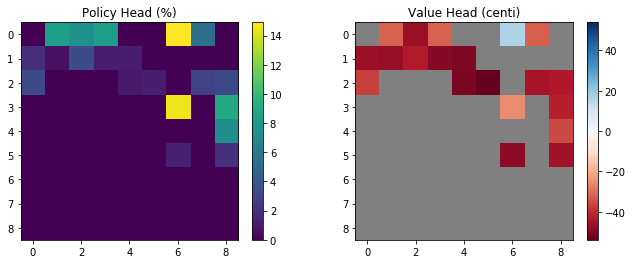

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.5755013227462769


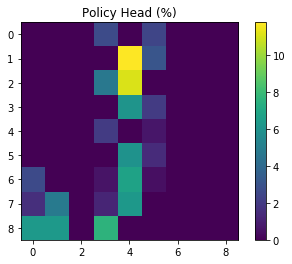

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()

### 32000 games
* Policy: outer corners
* Value: center corners

Value: 0.07501009851694107


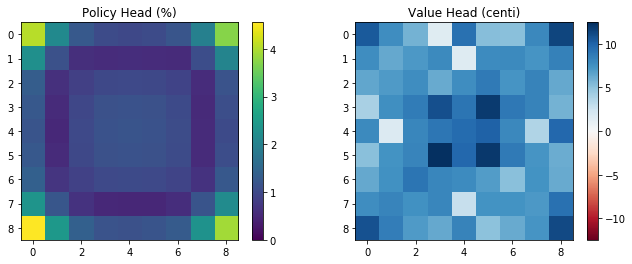

In [4]:
m = load_model('3200_32000bs2048lr0.1d0.001e6')

a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.23673416674137115


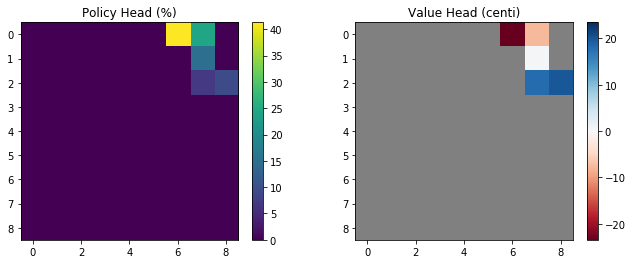

Value: 0.0037387043703347445


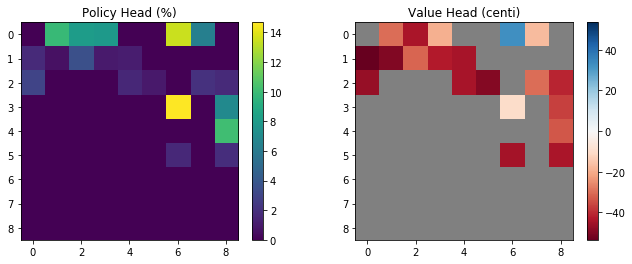

In [5]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

p = policy_head(m, c)
v = value_head(m, c)
plot_heads(p, v)

Value: -0.551163375377655


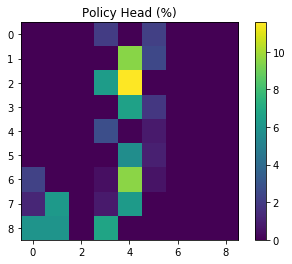

In [6]:
p = policy_head(m, win1)
plt.imshow(100*p, vmin=0)
plt.colorbar()
plt.title('Policy Head (%)')
plt.show()

In [7]:
t = NetTree(BigBoard(), Root(), model=m, noise=False)

In [8]:
for _ in range(1000): t.explore()
puct = (t.sign*t.Q + 2.0*t.P*np.sqrt(t.N.sum()))/t.N
print(t.N)
# print(t.Q_over_N())
# print(puct)
# print(t.terminal)
print(t.N.sum() - len(t.N))
print(t.v)

[ 55  19   9  20   9   5  10   6   8   6  11   7   6   4   5   8   9   9
   8  18  49   5   9  18   8   6   9   8   5   9  11   3   9   9   5   9
  17  13  21  12  22  15 101  14  18  10   5   8  10   4  12  10   5   8
  10   6   9  21  12   6  65  24  11  10   9   8   5   4   5   9  11   8
   7   6   9   5  10  23  10  20  49]
1000
0.08930777974089023


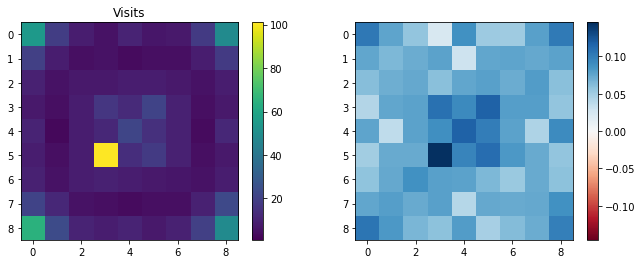

In [9]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
v = t.N.reshape(9, 9)
v = torch.tensor(v).view(3, 3, 3, 3)
v = torch.cat(v.chunk(3, dim=0), dim=2)
v = torch.cat(v.chunk(3, dim=1), dim=3)
v = v.squeeze().numpy()
plt.imshow(v, vmin=1)
plt.colorbar()
plt.title('Visits')

plt.subplot(122)
v = t.Q_over_N().reshape(9, 9)
v = torch.tensor(v).view(3, 3, 3, 3)
v = torch.cat(v.chunk(3, dim=0), dim=2)
v = torch.cat(v.chunk(3, dim=1), dim=3)
v = v.squeeze().numpy()
vmax = np.max(np.abs(v))
plt.imshow(v, vmin=-vmax, vmax=vmax, cmap=cm)
plt.colorbar()

plt.show()

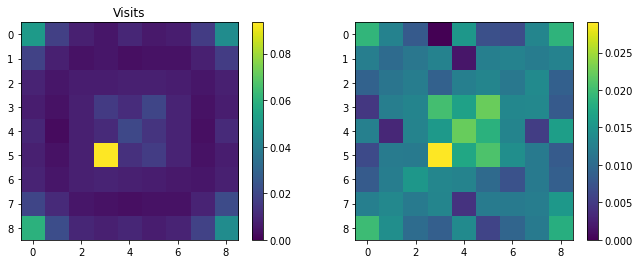

In [10]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
v = t.N.reshape(9, 9)
v = v / v.max()
v **= 1.0
v /= v.sum()
v = torch.tensor(v).view(3, 3, 3, 3)
v = torch.cat(v.chunk(3, dim=0), dim=2)
v = torch.cat(v.chunk(3, dim=1), dim=3)
v = v.squeeze().numpy()
plt.imshow(v, vmin=0)
plt.colorbar()
plt.title('Visits')

plt.subplot(122)
v = t.Q_over_N().reshape(9, 9)
v = v - v.min()
v **= 1.0
v /= v.sum()
v = torch.tensor(v).view(3, 3, 3, 3)
v = torch.cat(v.chunk(3, dim=0), dim=2)
v = torch.cat(v.chunk(3, dim=1), dim=3)
v = v.squeeze().numpy()
vmax = np.max(np.abs(v))
plt.imshow(v, vmin=0)
plt.colorbar()

plt.show()